In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_64684/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Tau 1 Calibration

Requirements:
1. Play Constant Amplitude Segment of amp: 1, duration: tau_1
2. Play Two-Sigma Gaussian Falling Edge between amp=1 and amp=meas_amp
3. Play Constant Amplitude Segment of amp: meas_amp, duration: 4 * x_pulse.duration
Play X Tone right after gaussian falling edge, and use this to measure photon population.\
For Reference center the photon measurement near the predicted freq from the SS measurement of the default photons

In [4]:
ac_span = 20.0 * MHz
chi = -0.65 * MHz
normal_photons = 43.0
center_freq = normal_photons * chi
num_experiments = 48
ac_freq_linspace = np.linspace(-0.5 * ac_span + center_freq, 0.5 * ac_span + center_freq, num_experiments)
precision = ac_freq_linspace[1] - ac_freq_linspace[0]

tau_1_estimate = 45 * ns
num_tau_1_vals = 12
tau_1_span = 30 * ns
tau_1_linspace = np.linspace(-0.5 * tau_1_span + tau_1_estimate, 0.5 * tau_1_span + tau_1_estimate, num_tau_1_vals)
tau_1_precision = tau_1_linspace[1] - tau_1_linspace[0]
print(tau_1_linspace/ns)

print(f"Freq Linspace starting from {ac_freq_linspace[0]/MHz}MHz to {ac_freq_linspace[-1]/MHz}MHz with step: {precision/MHz}MHz")
print(f"Freq Linspace starting from {int(1e3*tau_1_linspace[0]/ns)/1e3}ns to {int(1e3*tau_1_linspace[-1]/ns)/1e3}ns with step: {int(1e3*tau_1_precision/ns)/1e3}ns")

[30.         32.72727273 35.45454545 38.18181818 40.90909091 43.63636364
 46.36363636 49.09090909 51.81818182 54.54545455 57.27272727 60.        ]
Freq Linspace starting from -37.95MHz to -17.95MHz with step: 0.4255319148936197MHz
Freq Linspace starting from 30.0ns to 60.0ns with step: 2.727ns


In [5]:
# Generate Tau 1 Waveform for an input tau_1

from helper_funcs.utils import *

def generate_tau_1_waveform(tau_1):
    # First Segment: Constant Amplitude of duration tau_1
    # # Second Segment: Gaussian Falling Edge of duration 2 * sigma
    # Third Segment: Constant Amplitude of duration 4 * sigma

    sigma_sec = measure_pulse.sigma * dt
    amp = measure_pulse.amp

    total_duration_sec = tau_1 + 2 * sigma_sec + 4 * sigma_sec
    linspace_len = get_closest_multiple_of_16(get_dt_from(total_duration_sec))
    ts = np.arange(linspace_len) * total_duration_sec / linspace_len

    pulse_waveform = np.heaviside(tau_1 - ts, 0.)
    # gauss_fall_edge_1 = (1. - amp) * np.exp(-((ts - tau_1) / (np.sqrt(2) * sigma_sec))**2) + amp
    # pulse_waveform += gauss_fall_edge_1 * (np.heaviside(tau_1 + 2 * sigma_sec - ts, 0.) - np.heaviside(tau_1 - ts, 0.))
    pulse_waveform += amp * (np.heaviside(tau_1 + 6 * sigma_sec - ts, 0.) - np.heaviside(tau_1 + 0 * sigma_sec - ts , 0.))

    return pulse_waveform

576


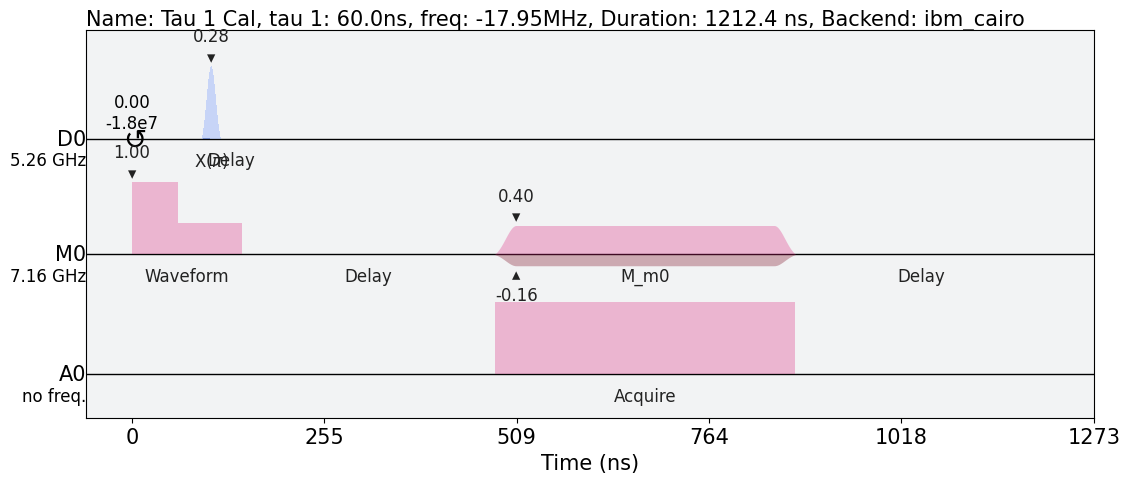

In [6]:
tau_1_exp = []

for tau_1 in tau_1_linspace:
    tau_1_pulse = pulse.Waveform(generate_tau_1_waveform(tau_1))

    for freq_shift in ac_freq_linspace:
        with pulse.build(backend=backend, default_alignment='sequential', name=f'Tau 1 Cal, tau 1: {int(1e3 * tau_1/ns)/1e3}ns, freq: {int(1e3*freq_shift/MHz)/1e3}MHz') as tau_1_sched:
            meas_chan = pulse.measure_channel(qubit)
            qubit_chan = pulse.drive_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            with pulse.align_right():
                pulse.play(tau_1_pulse, meas_chan)
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(2 * measure_pulse.sigma, qubit_chan)
            
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_1_exp.append(tau_1_sched)

print(len(tau_1_exp))
tau_1_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [7]:
exp_1, exp_2 = np.array(tau_1_exp).reshape(2, -1).tolist()
acquisition_checker(exp_1)
acquisition_checker(exp_2)

num_shots = 4096
rep_delay = 499.0 * 1e-6

## Tau Reset Calibration

1. Play Default Measurement Pulse
2. Add Variable Duration (tau_3) amp=-1.0 segment
3. Wait 2 Sigma
4. Play Qubit Tone, delay, and then measure

In [8]:
num_experiments_3 = 48
ac_freq_linspace_reset = np.linspace(-0.5 * ac_span, 0.5 * ac_span, num_experiments)
precision_reset = ac_freq_linspace_reset[1] - ac_freq_linspace_reset[0]

tau_3_estimate = 28 * ns
num_tau_3_vals = 12
tau_3_span = 30 * ns
tau_3_linspace = np.linspace(-0.5 * tau_3_span + tau_3_estimate, 0.5 * tau_3_span + tau_3_estimate, num_tau_3_vals)
tau_3_precision = tau_3_linspace[1] - tau_3_linspace[0]
print(tau_3_linspace/ns)

print(f"Freq Linspace starting from {ac_freq_linspace_reset[0]/MHz}MHz to {ac_freq_linspace_reset[-1]/MHz}MHz with step: {precision_reset/MHz}MHz")
print(f"Freq Linspace starting from {int(1e3*tau_3_linspace[0]/ns)/1e3}ns to {int(1e3*tau_3_linspace[-1]/ns)/1e3}ns with step: {int(1e3*tau_3_precision/ns)/1e3}ns")

[13.         15.72727273 18.45454545 21.18181818 23.90909091 26.63636364
 29.36363636 32.09090909 34.81818182 37.54545455 40.27272727 43.        ]
Freq Linspace starting from -10.0MHz to 10.0MHz with step: 0.42553191489361786MHz
Freq Linspace starting from 13.0ns to 43.0ns with step: 2.727ns


In [9]:
# Generate Tau_R Waveform for an input tau_3

def generate_tau_3_waveform(tau_3):
    # First Segment: Constant Amplitude of duration meas_duration
    # # Second Segment: Gaussian Falling Edge of duration 2 * sigma
    # Third Segment: Constant Amplitude of duration tau_3

    normal_meas_duration = measure_pulse.duration * dt
    amp = measure_pulse.amp

    total_duration_sec = normal_meas_duration + tau_3
    linspace_len = get_closest_multiple_of_16(get_dt_from(total_duration_sec))
    ts = np.arange(linspace_len) * total_duration_sec / linspace_len

    pulse_waveform = amp * np.heaviside(normal_meas_duration - ts, 0.)
    pulse_waveform -= 1.0 * (np.heaviside(normal_meas_duration + tau_3 - ts, 0.) - np.heaviside(normal_meas_duration - ts , 0.))

    # plt.plot(ts/ns, pulse_waveform)
    # plt.show()

    return pulse_waveform

576


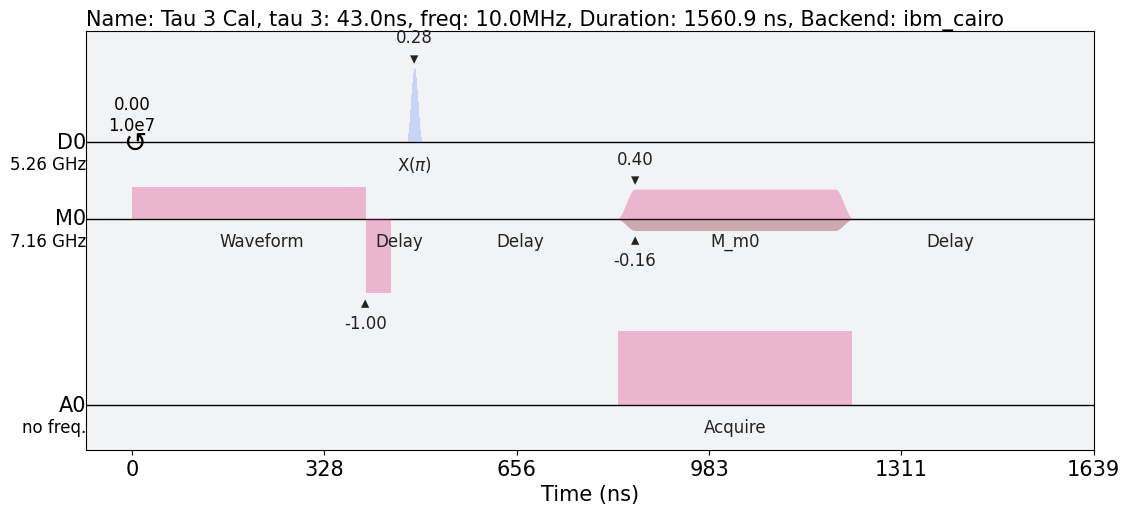

In [12]:
tau_3_exp = []

for tau_3 in tau_3_linspace:
    tau_3_pulse = pulse.Waveform(generate_tau_3_waveform(tau_3))

    for freq_shift in ac_freq_linspace_reset:
        with pulse.build(backend=backend, default_alignment='sequential', name=f'Tau 3 Cal, tau 3: {int(1e3 * tau_3/ns)/1e3}ns, freq: {int(1e3*freq_shift/MHz)/1e3}MHz') as tau_3_sched:
            meas_chan = pulse.measure_channel(qubit)
            qubit_chan = pulse.drive_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(tau_3_pulse, meas_chan)
            pulse.delay(2 * measure_pulse.sigma, meas_chan)
            pulse.play(x_pulse, qubit_chan)
            
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_3_exp.append(tau_3_sched)

print(len(tau_3_exp))
tau_3_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [13]:
exp_3, exp_4 = np.array(tau_3_exp).reshape(2, -1).tolist()
acquisition_checker(exp_3)
acquisition_checker(exp_4)

In [15]:
job_experiment = backend.run(exp_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 